# Sparse Reconstruction Uncertainty Analysis

This notebook analyzes the uncertainty in sparse tensor tomography reconstructions by:
1. Computing a ground truth reconstruction using all available projections (240 angles)
2. Fixing a sparse subset of 60 projections
3. Repeatedly sampling 80% of these 60 projections (48 projections)
4. Computing k reconstructions and analyzing their standard deviation
5. Visualizing the uncertainty across spherical harmonic coefficients

In [83]:
try:
    from mumott.data_handling import DataContainer
except:
    !sh ../scripts/setup.sh

In [84]:
import sys
sys.path.insert(0, '/myhome/smartt')

import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from tqdm import tqdm
import copy

# Import mumott modules
from mumott.data_handling import DataContainer
from mumott.methods.basis_sets import SphericalHarmonics
from mumott.methods.projectors import SAXSProjector, SAXSProjectorCUDA
from mumott.methods.residual_calculators import GradientResidualCalculator
from mumott.optimization.loss_functions import SquaredLoss
from mumott.optimization.optimizers import LBFGS
from mumott.optimization.regularizers import Laplacian

# Import custom functions
from smartt.data_processing import _perform_reconstruction

%matplotlib inline

/opt/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


## 1. Configuration

In [85]:
# Paths
data_path = '/myhome/data/smartt/shared/frogbone_test/dataset_qbin_0000.h5'

# Reconstruction parameters
ell_max = 8
maxiter = 20
regularization_weight = 1.0
use_cuda = False  # Set to False if CUDA is not available

# Sparse sampling parameters
num_projections_sparse = 60  # Fixed sparse subset
subsample_fraction = 0.8     # Sample 80% of the 60 projections
num_subsamples = int(subsample_fraction * num_projections_sparse)          # 80% of 60
num_experiments = 5         # Number of random subsampling experiments

# Random seed for reproducibility
seed = 42
np.random.seed(seed)

print(f"Configuration:")
print(f"  ell_max: {ell_max}")
print(f"  Fixed sparse subset: {num_projections_sparse} projections")
print(f"  Subsample size: {num_subsamples} projections (80%)")
print(f"  Number of experiments: {num_experiments}")
print(f"  Using {'CUDA' if use_cuda else 'CPU'}")

Configuration:
  ell_max: 8
  Fixed sparse subset: 60 projections
  Subsample size: 48 projections (80%)
  Number of experiments: 5
  Using CPU


## 2. Load Dataset and Compute Ground Truth

We'll compute the ground truth reconstruction using all 240 available projections.

In [86]:
# Load data container
print("Loading data container...")
dc_full = DataContainer(data_path, nonfinite_replacement_value=0)
total_projections = len(dc_full.projections)

print(f"\nDataset information:")
print(f"  Total projections available: {total_projections}")
print(f"  Volume shape: {dc_full.geometry.volume_shape}")

Loading data container...
INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.

Dataset information:
  Total projections available: 240
  Volume shape: [65 82 65]


In [87]:
# Compute ground truth reconstruction with all projections
print(f"\nComputing ground truth reconstruction with all {total_projections} projections...")
print("This may take several minutes...\n")

ground_truth = _perform_reconstruction(
    dc=dc_full,
    ell_max=ell_max,
    maxiter=maxiter,
    regularization_weight=regularization_weight,
    use_cuda=use_cuda,
    verbose=True
)

print(f"\nGround truth shape: {ground_truth.shape}")
volume_shape = ground_truth.shape[:3]
num_coeffs = ground_truth.shape[3]
print(f"Volume shape: {volume_shape}")
print(f"Number of coefficients: {num_coeffs}")

/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],



Computing ground truth reconstruction with all 240 projections...
This may take several minutes...

Running optimization...
  0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 60%|██████    | 12/20 [02:08<01:25, 10.73s/it]

Ground truth shape: (65, 82, 65, 45)
Volume shape: (65, 82, 65)
Number of coefficients: 45


## 3. Select Fixed Sparse Subset

Randomly select 60 projections from the full set. This subset will remain fixed for all experiments.

In [88]:
# Randomly select fixed sparse subset of 60 projections
np.random.seed(seed)
fixed_sparse_indices = np.random.choice(
    total_projections,
    size=num_projections_sparse,
    replace=False
)
fixed_sparse_indices = np.arange(num_projections_sparse)

fixed_sparse_indices = np.sort(fixed_sparse_indices)

print(f"Fixed sparse subset (60 projections):")
print(f"  Indices: {fixed_sparse_indices[:10]}...{fixed_sparse_indices[-10:]}")
print(f"  Min: {fixed_sparse_indices.min()}, Max: {fixed_sparse_indices.max()}")

Fixed sparse subset (60 projections):
  Indices: [0 1 2 3 4 5 6 7 8 9]...[50 51 52 53 54 55 56 57 58 59]
  Min: 0, Max: 59


## 4. Run Multiple Sparse Reconstruction Experiments

For each experiment:
1. Randomly sample 80% of the fixed 60 projections (48 projections)
2. Perform sparse reconstruction with these 48 projections
3. Store the result

In [89]:
# Pre-allocate array to store all reconstructions
all_reconstructions = np.zeros(
    (num_experiments, *volume_shape, num_coeffs),
    dtype=np.float32
)

# Store the indices used in each experiment
subsample_indices_list = []

print(f"\nRunning {num_experiments} sparse reconstruction experiments...")
print(f"Each experiment uses {num_subsamples} randomly sampled projections from the fixed subset of 60.\n")

for exp_idx in tqdm(range(num_experiments), desc="Experiments"):
    # Randomly sample 80% of the fixed sparse subset
    subsample_indices = np.random.choice(
        fixed_sparse_indices,
        size=num_subsamples,
        replace=False
    )

    
    subsample_indices = np.sort(subsample_indices)
    subsample_indices_list.append(subsample_indices)
    
    # Create a fresh data container with only the subsampled projections
    dc_subsample = DataContainer(data_path, nonfinite_replacement_value=0)
    
    # Remove projections not in the subsample
    all_indices = np.arange(total_projections)
    indices_to_delete = [i for i in all_indices if i not in subsample_indices]
    
    for i in sorted(indices_to_delete, reverse=True):
        del dc_subsample.projections[i]
    
    # Perform reconstruction
    reconstruction = _perform_reconstruction(
        dc=dc_subsample,
        ell_max=ell_max,
        maxiter=maxiter,
        regularization_weight=regularization_weight,
        use_cuda=use_cuda,
        verbose=False
    )
    
    # Store reconstruction
    all_reconstructions[exp_idx] = reconstruction
    
    # Clean up
    del dc_subsample, reconstruction

print(f"\nCompleted {num_experiments} experiments.")
print(f"All reconstructions shape: {all_reconstructions.shape}")


Running 5 sparse reconstruction experiments...
Each experiment uses 48 randomly sampled projections from the fixed subset of 60.



Experiments:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 65%|██████▌   | 13/20 [00:47<00:25,  3.66s/it]


Experiments:  20%|██        | 1/5 [00:48<03:15, 48.97s/it]

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 70%|███████   | 14/20 [00:50<00:21,  3.57s/it]


Experiments:  40%|████      | 2/5 [01:40<02:31, 50.41s/it]

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 65%|██████▌   | 13/20 [00:47<00:25,  3.66s/it]


Experiments:  60%|██████    | 3/5 [02:29<01:39, 49.77s/it]

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 65%|██████▌   | 13/20 [00:47<00:25,  3.68s/it]


Experiments:  80%|████████  | 4/5 [03:18<00:49, 49.55s/it]

INFO:Rotation matrices were loaded from the input file.
INFO:Sample geometry loaded from file.
INFO:Detector geometry loaded from file.


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


 70%|███████   | 14/20 [00:49<00:21,  3.56s/it]


Experiments: 100%|██████████| 5/5 [04:09<00:00, 49.98s/it]


Completed 5 experiments.
All reconstructions shape: (5, 65, 82, 65, 45)


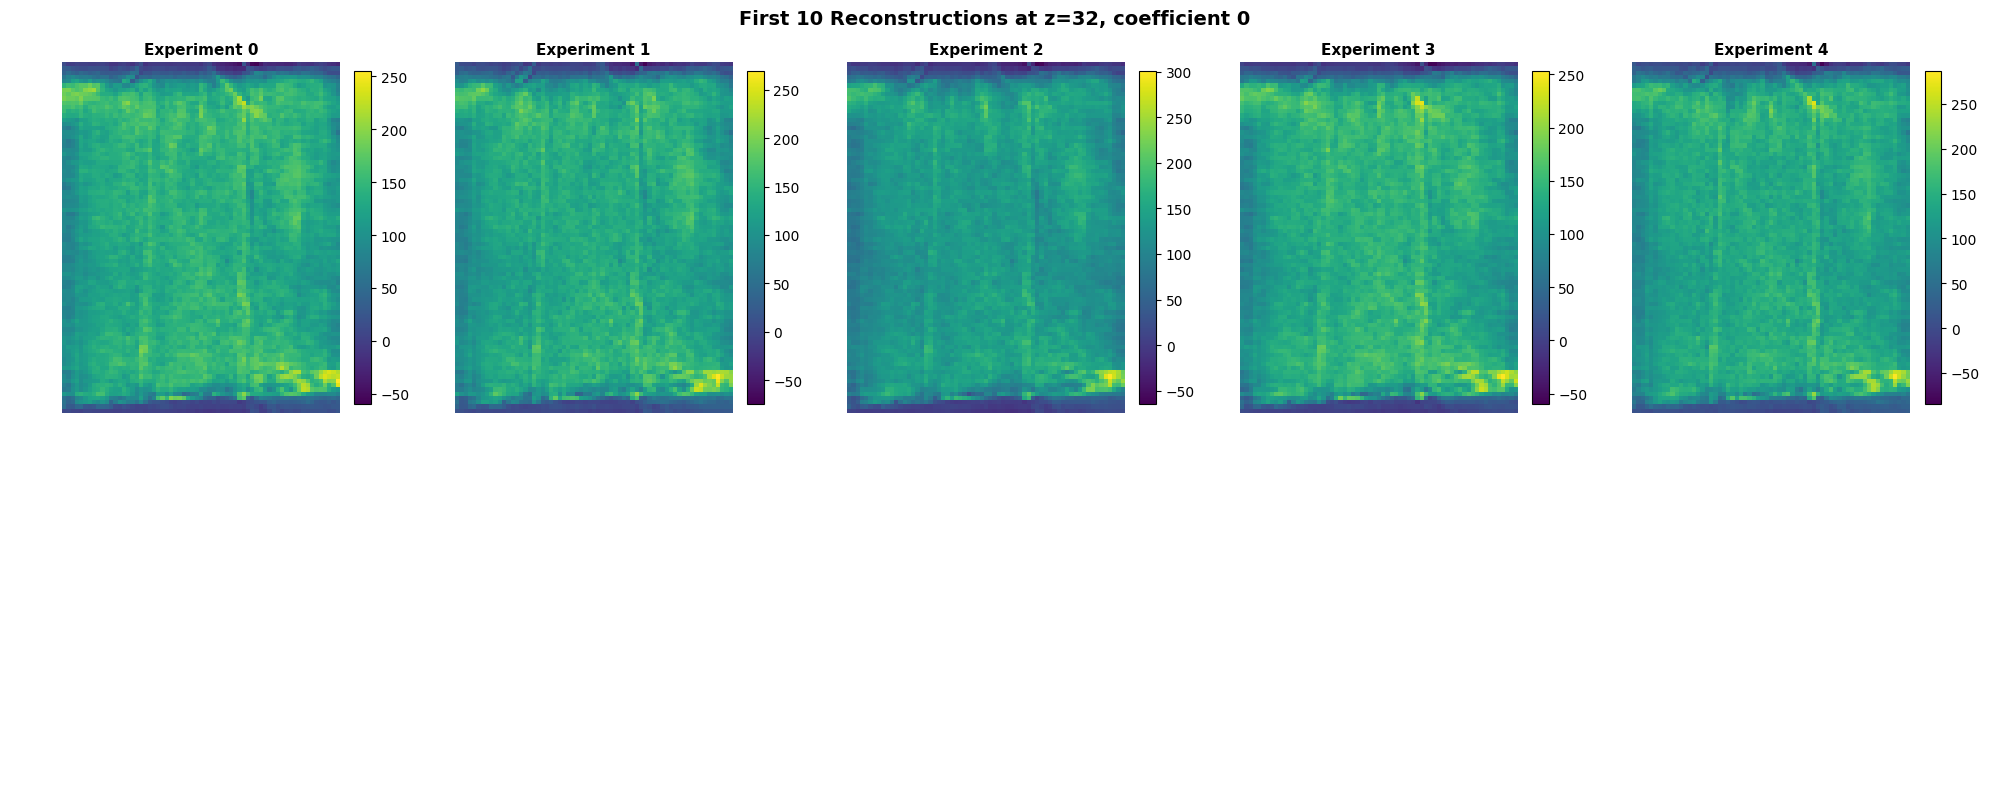

In [113]:
# Plot first 10 slices of all_reconstructions
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    if i < num_experiments:
        slice_data = all_reconstructions[i, 32, :, :, 0]
        im = axes[i].imshow(slice_data, cmap='viridis')
        axes[i].set_title(f'Experiment {i}', fontsize=11, fontweight='bold')
        axes[i].axis('off')
        plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
    else:
        axes[i].axis('off')

fig.suptitle('First 10 Reconstructions at z=32, coefficient 0', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Compute Standard Deviation Across Experiments

Calculate the standard deviation across all experiments to quantify reconstruction uncertainty.

In [91]:
# Compute mean and standard deviation across experiments
mean_reconstruction = np.mean(all_reconstructions, axis=0)
std_reconstruction = np.std(all_reconstructions, axis=0)

print(f"Mean reconstruction shape: {mean_reconstruction.shape}")
print(f"Std reconstruction shape: {std_reconstruction.shape}")

# Compute statistics
print(f"\nStandard deviation statistics (across all voxels and coefficients):")
print(f"  Mean std: {np.mean(std_reconstruction):.6f}")
print(f"  Median std: {np.median(std_reconstruction):.6f}")
print(f"  Min std: {np.min(std_reconstruction):.6f}")
print(f"  Max std: {np.max(std_reconstruction):.6f}")

# Per-coefficient statistics
print(f"\nPer-coefficient std statistics:")
for coeff_idx in range(num_coeffs):
    coeff_std = std_reconstruction[..., coeff_idx]
    print(f"  Coefficient {coeff_idx:2d}: mean={np.mean(coeff_std):.6f}, "
          f"median={np.median(coeff_std):.6f}, max={np.max(coeff_std):.6f}")

Mean reconstruction shape: (65, 82, 65, 45)
Std reconstruction shape: (65, 82, 65, 45)

Standard deviation statistics (across all voxels and coefficients):
  Mean std: 2.887366
  Median std: 1.947914
  Min std: 0.012578
  Max std: 194.996307

Per-coefficient std statistics:
  Coefficient  0: mean=4.692171, median=4.029456, max=54.993256
  Coefficient  1: mean=1.867071, median=1.417858, max=52.564171
  Coefficient  2: mean=2.198844, median=1.794105, max=41.360355
  Coefficient  3: mean=3.575954, median=2.851610, max=63.085869
  Coefficient  4: mean=3.537637, median=3.172249, max=23.383472
  Coefficient  5: mean=4.233640, median=2.899538, max=100.494293
  Coefficient  6: mean=2.852810, median=1.785431, max=113.578568
  Coefficient  7: mean=2.135460, median=1.654473, max=57.867420
  Coefficient  8: mean=1.857630, median=1.467043, max=48.874226
  Coefficient  9: mean=1.550307, median=1.076021, max=68.750145
  Coefficient 10: mean=3.511332, median=2.809191, max=62.841801
  Coefficient 11: m

## 6. Visualize Standard Deviation Slices

Plot slices through the 3D standard deviation volume for different spherical harmonic coefficients.

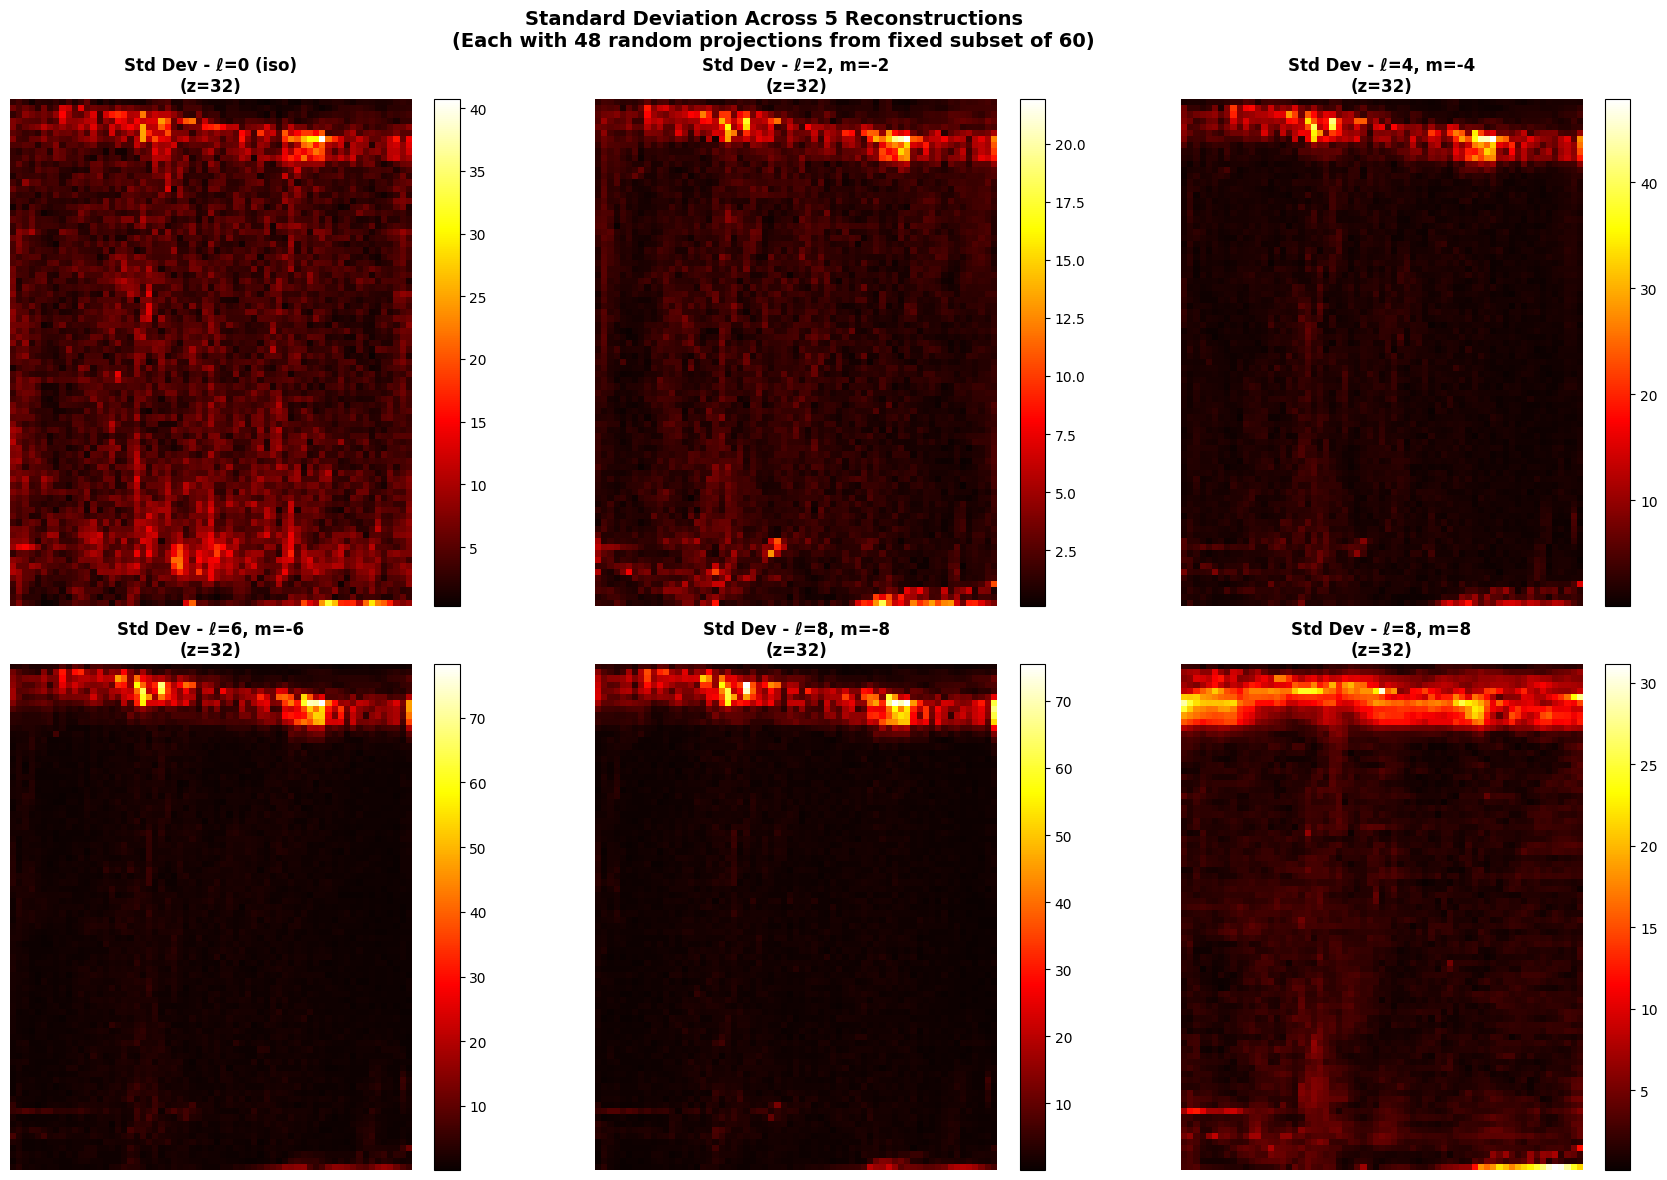

In [92]:
# Select coefficients to visualize
# Coefficient 0 is l=0 (isotropic), then l=2, l=4, l=6, l=8
coeffs_to_plot = [0, 1, 6, 15, 28, 44]  # Start of each l value: l=0, l=2, l=4, l=6, l=8, last coeff
coeff_labels = ['ℓ=0 (iso)', 'ℓ=2, m=-2', 'ℓ=4, m=-4', 'ℓ=6, m=-6', 'ℓ=8, m=-8', 'ℓ=8, m=8']

# Select middle slice
mid_z = volume_shape[2] // 2

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (coeff_idx, label) in enumerate(zip(coeffs_to_plot, coeff_labels)):
    std_slice = std_reconstruction[:, :, mid_z, coeff_idx]
    
    im = axes[idx].imshow(std_slice.T, cmap='hot', origin='lower')
    axes[idx].set_title(f'Std Dev - {label}\n(z={mid_z})', fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

fig.suptitle(f'Standard Deviation Across {num_experiments} Reconstructions\n'
             f'(Each with {num_subsamples} random projections from fixed subset of {num_projections_sparse})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Multiple Z-Slices for Selected Coefficients

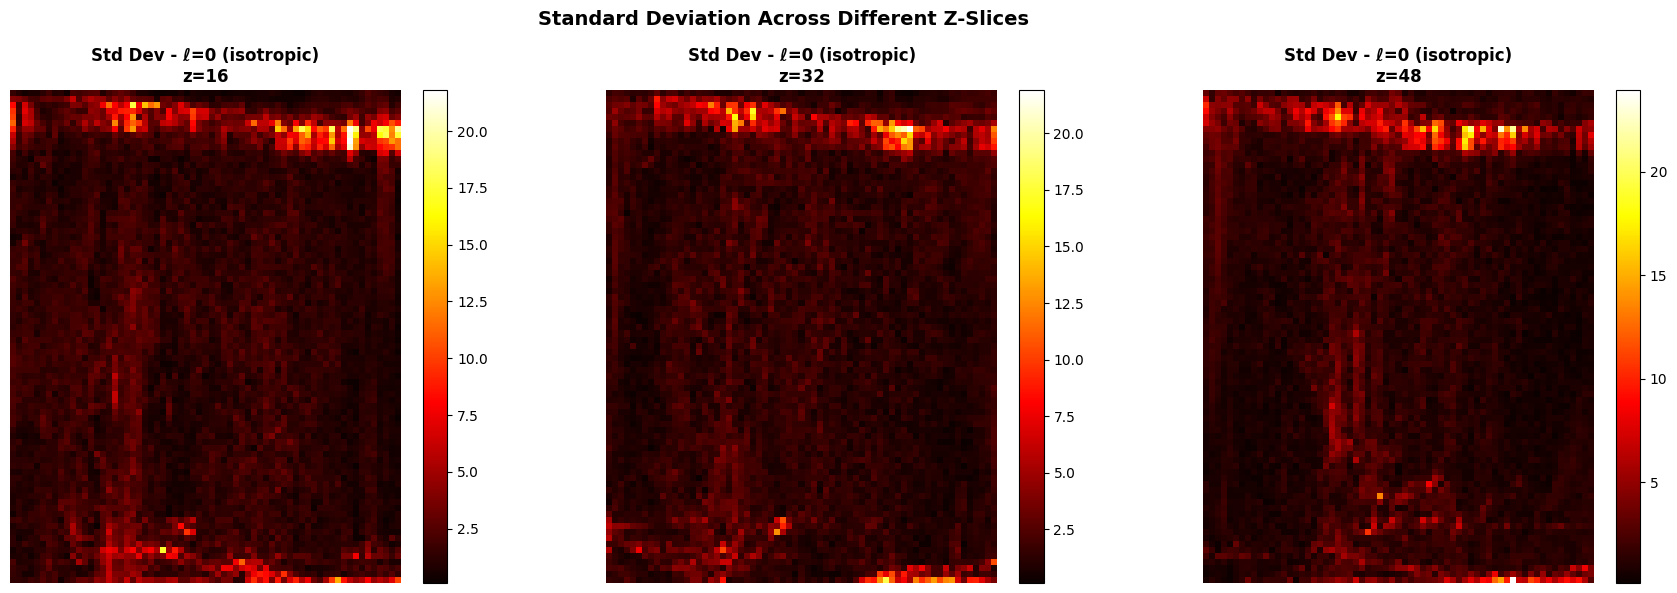

In [93]:
# Plot multiple z-slices for the isotropic component (l=0)
coeff_idx = 1
z_slices = [volume_shape[2]//4, volume_shape[2]//2, 3*volume_shape[2]//4]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, z in enumerate(z_slices):
    std_slice = std_reconstruction[:, :, z, coeff_idx]
    
    im = axes[idx].imshow(std_slice.T, cmap='hot', origin='lower')
    axes[idx].set_title(f'Std Dev - ℓ=0 (isotropic)\nz={z}', fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

fig.suptitle(f'Standard Deviation Across Different Z-Slices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Compare Mean Reconstruction vs Ground Truth

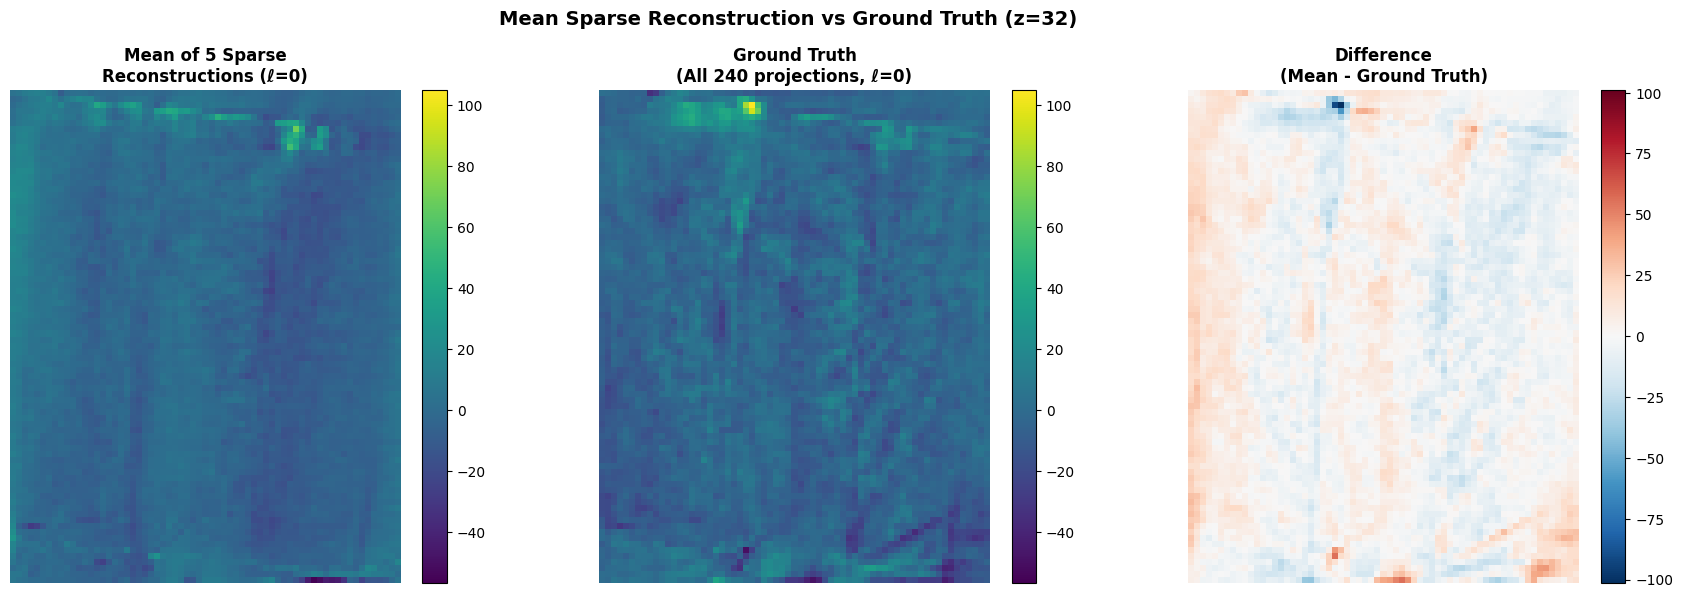


Error metrics (Mean reconstruction vs Ground truth):
  MSE: 327.324585
  MAE: 10.254478


In [94]:
# Compare mean of sparse reconstructions to ground truth
coeff_idx = 2  # Isotropic component
mid_z = volume_shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Determine shared colorbar limits
vmin = min(mean_reconstruction[:, :, mid_z, coeff_idx].min(),
           ground_truth[:, :, mid_z, coeff_idx].min())
vmax = max(mean_reconstruction[:, :, mid_z, coeff_idx].max(),
           ground_truth[:, :, mid_z, coeff_idx].max())

# Mean reconstruction
im0 = axes[0].imshow(mean_reconstruction[:, :, mid_z, coeff_idx].T,
                     cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title(f'Mean of {num_experiments} Sparse\nReconstructions (ℓ=0)', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Ground truth
im1 = axes[1].imshow(ground_truth[:, :, mid_z, coeff_idx].T,
                     cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title(f'Ground Truth\n(All {total_projections} projections, ℓ=0)', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Difference
diff = mean_reconstruction[:, :, mid_z, coeff_idx] - ground_truth[:, :, mid_z, coeff_idx]
im2 = axes[2].imshow(diff.T, cmap='RdBu_r', origin='lower',
                     vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
axes[2].set_title('Difference\n(Mean - Ground Truth)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

fig.suptitle(f'Mean Sparse Reconstruction vs Ground Truth (z={mid_z})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Compute error metrics
mse = np.mean((mean_reconstruction - ground_truth)**2)
mae = np.mean(np.abs(mean_reconstruction - ground_truth))
print(f"\nError metrics (Mean reconstruction vs Ground truth):")
print(f"  MSE: {mse:.6f}")
print(f"  MAE: {mae:.6f}")

## 9. Histogram of Standard Deviations

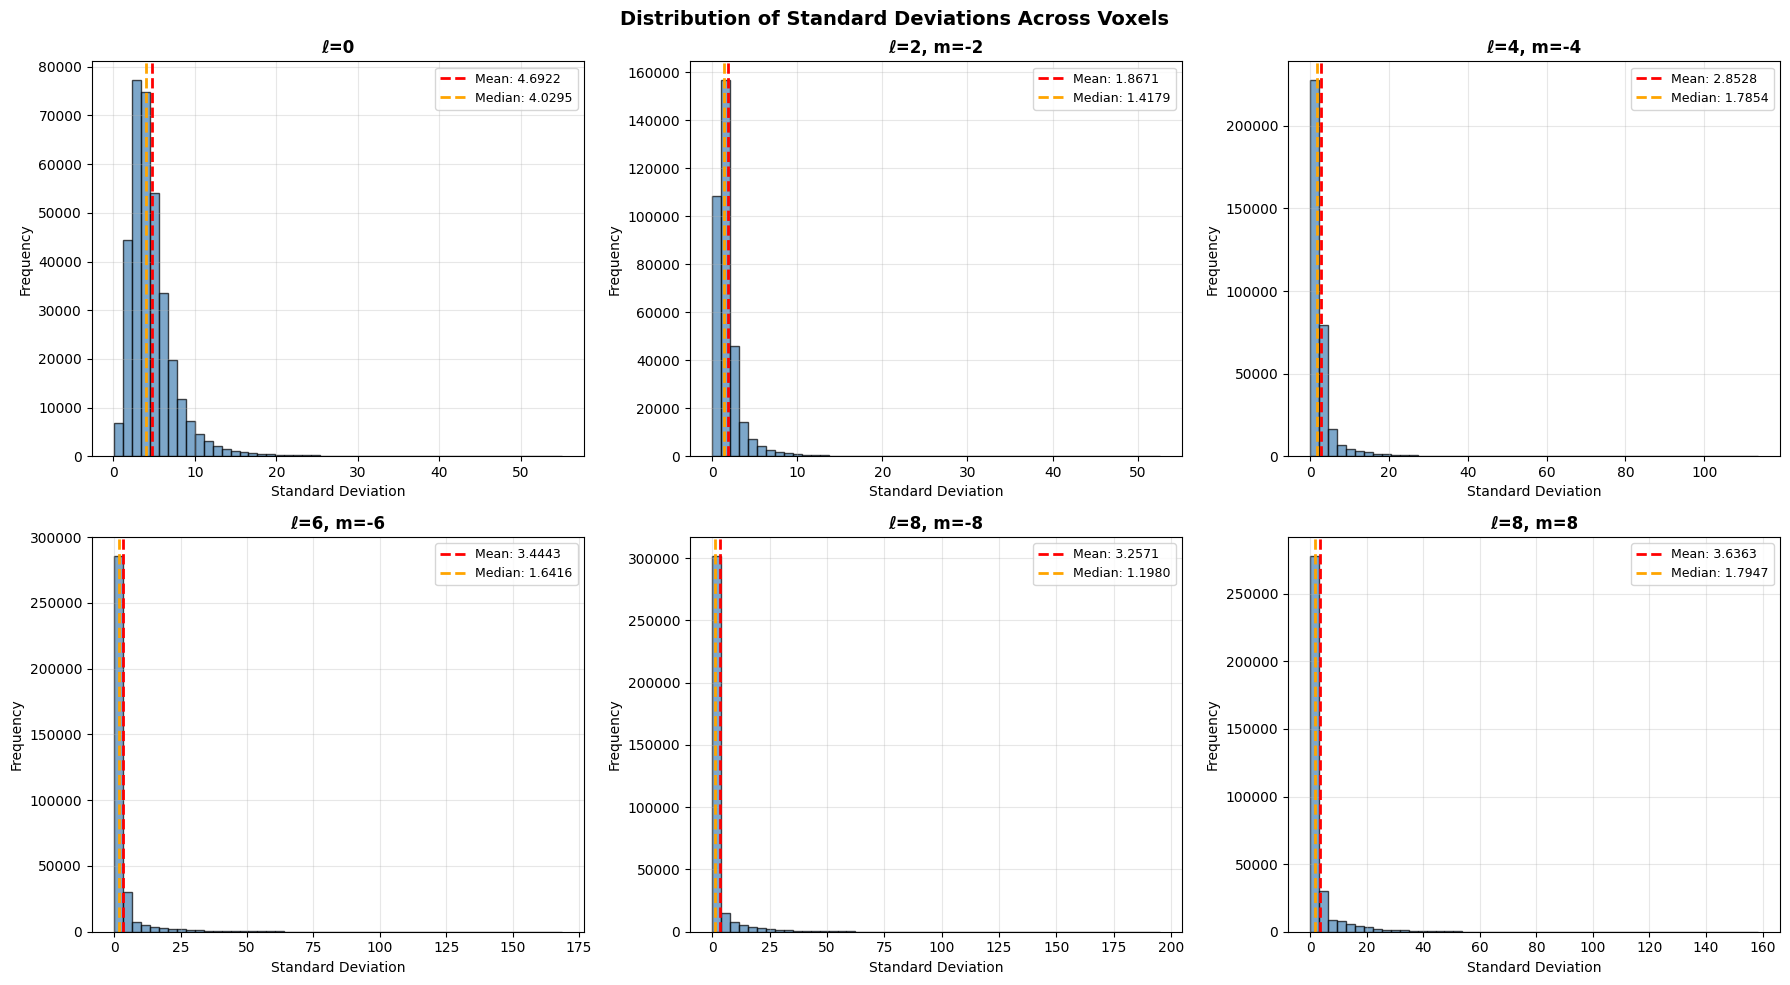

In [95]:
# Plot histograms of standard deviations for different coefficients
coeffs_to_plot = [0, 1, 6, 15, 28, 44]
coeff_labels = ['ℓ=0', 'ℓ=2, m=-2', 'ℓ=4, m=-4', 'ℓ=6, m=-6', 'ℓ=8, m=-8', 'ℓ=8, m=8']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (coeff_idx, label) in enumerate(zip(coeffs_to_plot, coeff_labels)):
    std_flat = std_reconstruction[..., coeff_idx].flatten()
    
    axes[idx].hist(std_flat, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_xlabel('Standard Deviation', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{label}', fontsize=12, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)
    
    # Add statistics
    mean_std = np.mean(std_flat)
    median_std = np.median(std_flat)
    axes[idx].axvline(mean_std, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_std:.4f}')
    axes[idx].axvline(median_std, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_std:.4f}')
    axes[idx].legend(fontsize=9)

fig.suptitle(f'Distribution of Standard Deviations Across Voxels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 10. Coefficient-wise Analysis

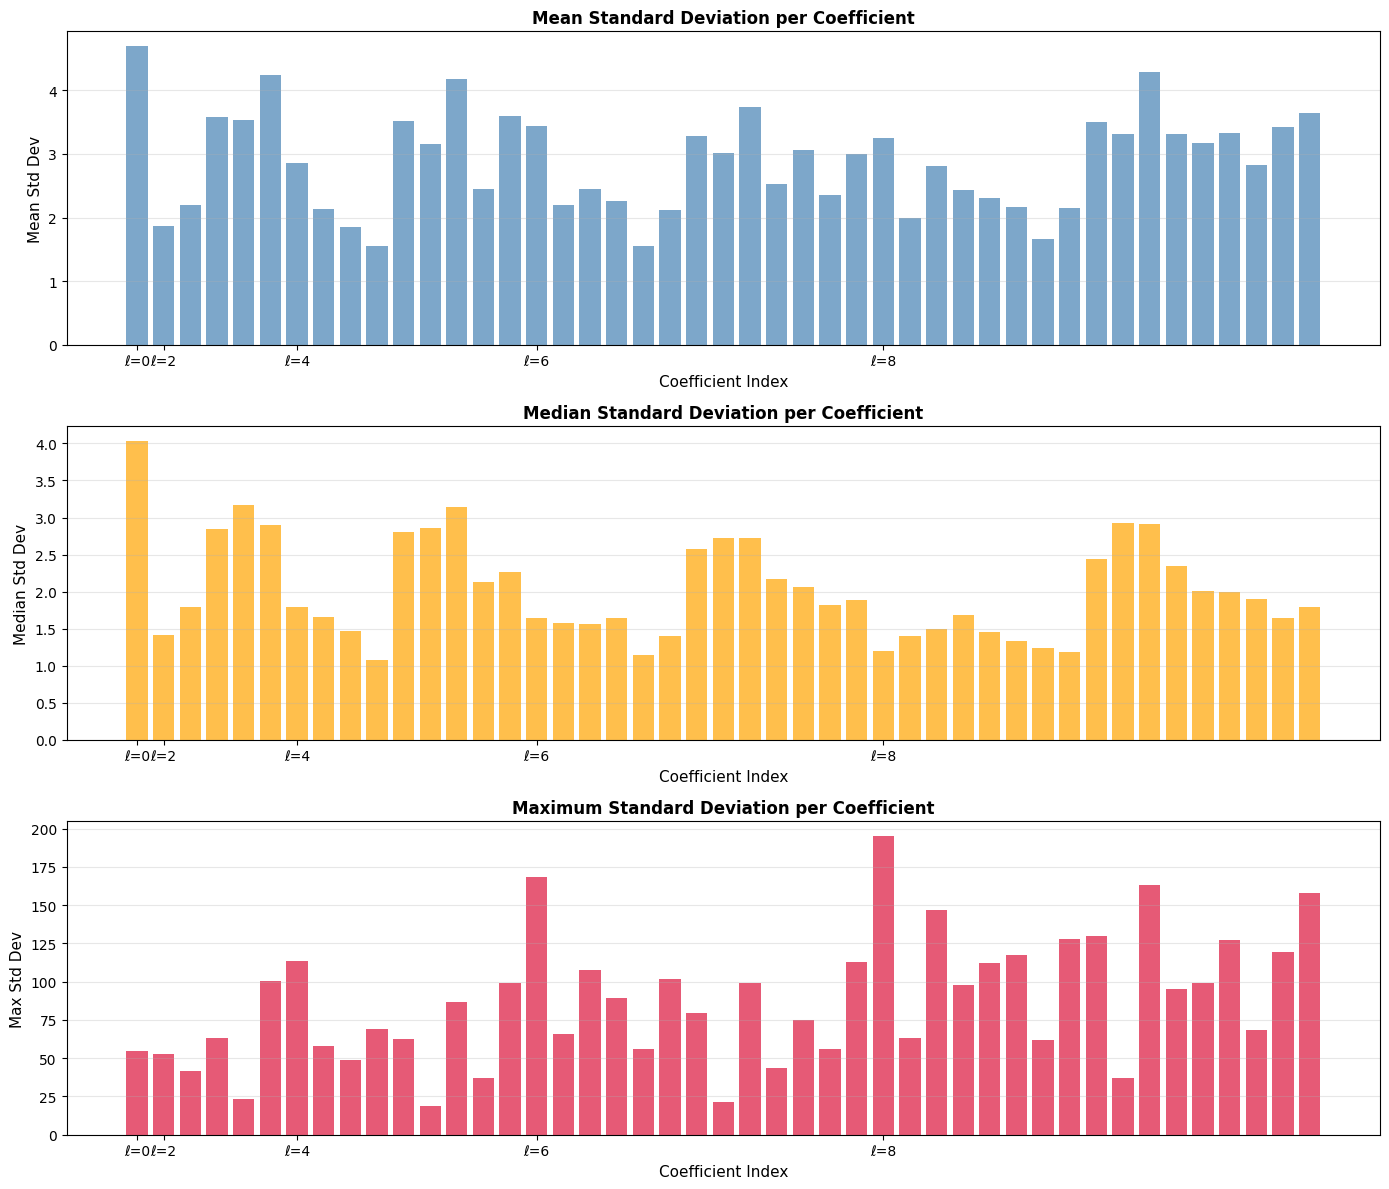

In [96]:
# Compute mean std for each coefficient
mean_std_per_coeff = np.array([np.mean(std_reconstruction[..., i]) for i in range(num_coeffs)])
median_std_per_coeff = np.array([np.median(std_reconstruction[..., i]) for i in range(num_coeffs)])
max_std_per_coeff = np.array([np.max(std_reconstruction[..., i]) for i in range(num_coeffs)])

fig, axes = plt.subplots(3, 1, figsize=(14, 12))

x = np.arange(num_coeffs)

# Mean std per coefficient
axes[0].bar(x, mean_std_per_coeff, color='steelblue', alpha=0.7)
axes[0].set_xlabel('Coefficient Index', fontsize=11)
axes[0].set_ylabel('Mean Std Dev', fontsize=11)
axes[0].set_title('Mean Standard Deviation per Coefficient', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# Median std per coefficient
axes[1].bar(x, median_std_per_coeff, color='orange', alpha=0.7)
axes[1].set_xlabel('Coefficient Index', fontsize=11)
axes[1].set_ylabel('Median Std Dev', fontsize=11)
axes[1].set_title('Median Standard Deviation per Coefficient', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Max std per coefficient
axes[2].bar(x, max_std_per_coeff, color='crimson', alpha=0.7)
axes[2].set_xlabel('Coefficient Index', fontsize=11)
axes[2].set_ylabel('Max Std Dev', fontsize=11)
axes[2].set_title('Maximum Standard Deviation per Coefficient', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# Add ℓ value labels
for ax in axes:
    ax.set_xticks([0, 1, 6, 15, 28])
    ax.set_xticklabels(['ℓ=0', 'ℓ=2', 'ℓ=4', 'ℓ=6', 'ℓ=8'])

plt.tight_layout()
plt.show()

## 11. Relative Uncertainty

Compute relative uncertainty (std / mean) to understand uncertainty relative to signal strength.

In [97]:
# Compute relative uncertainty (coefficient of variation)
# Add small epsilon to avoid division by zero
epsilon = 1e-10
relative_uncertainty = std_reconstruction / (np.abs(mean_reconstruction) + epsilon)

# Clip extreme values for visualization
relative_uncertainty_clipped = np.clip(relative_uncertainty, 0, 5)

print(f"Relative uncertainty statistics:")
print(f"  Mean: {np.mean(relative_uncertainty):.4f}")
print(f"  Median: {np.median(relative_uncertainty):.4f}")
print(f"  90th percentile: {np.percentile(relative_uncertainty, 90):.4f}")
print(f"  99th percentile: {np.percentile(relative_uncertainty, 99):.4f}")

Relative uncertainty statistics:
  Mean: 4.1640
  Median: 0.3831
  90th percentile: 2.2017
  99th percentile: 22.0600


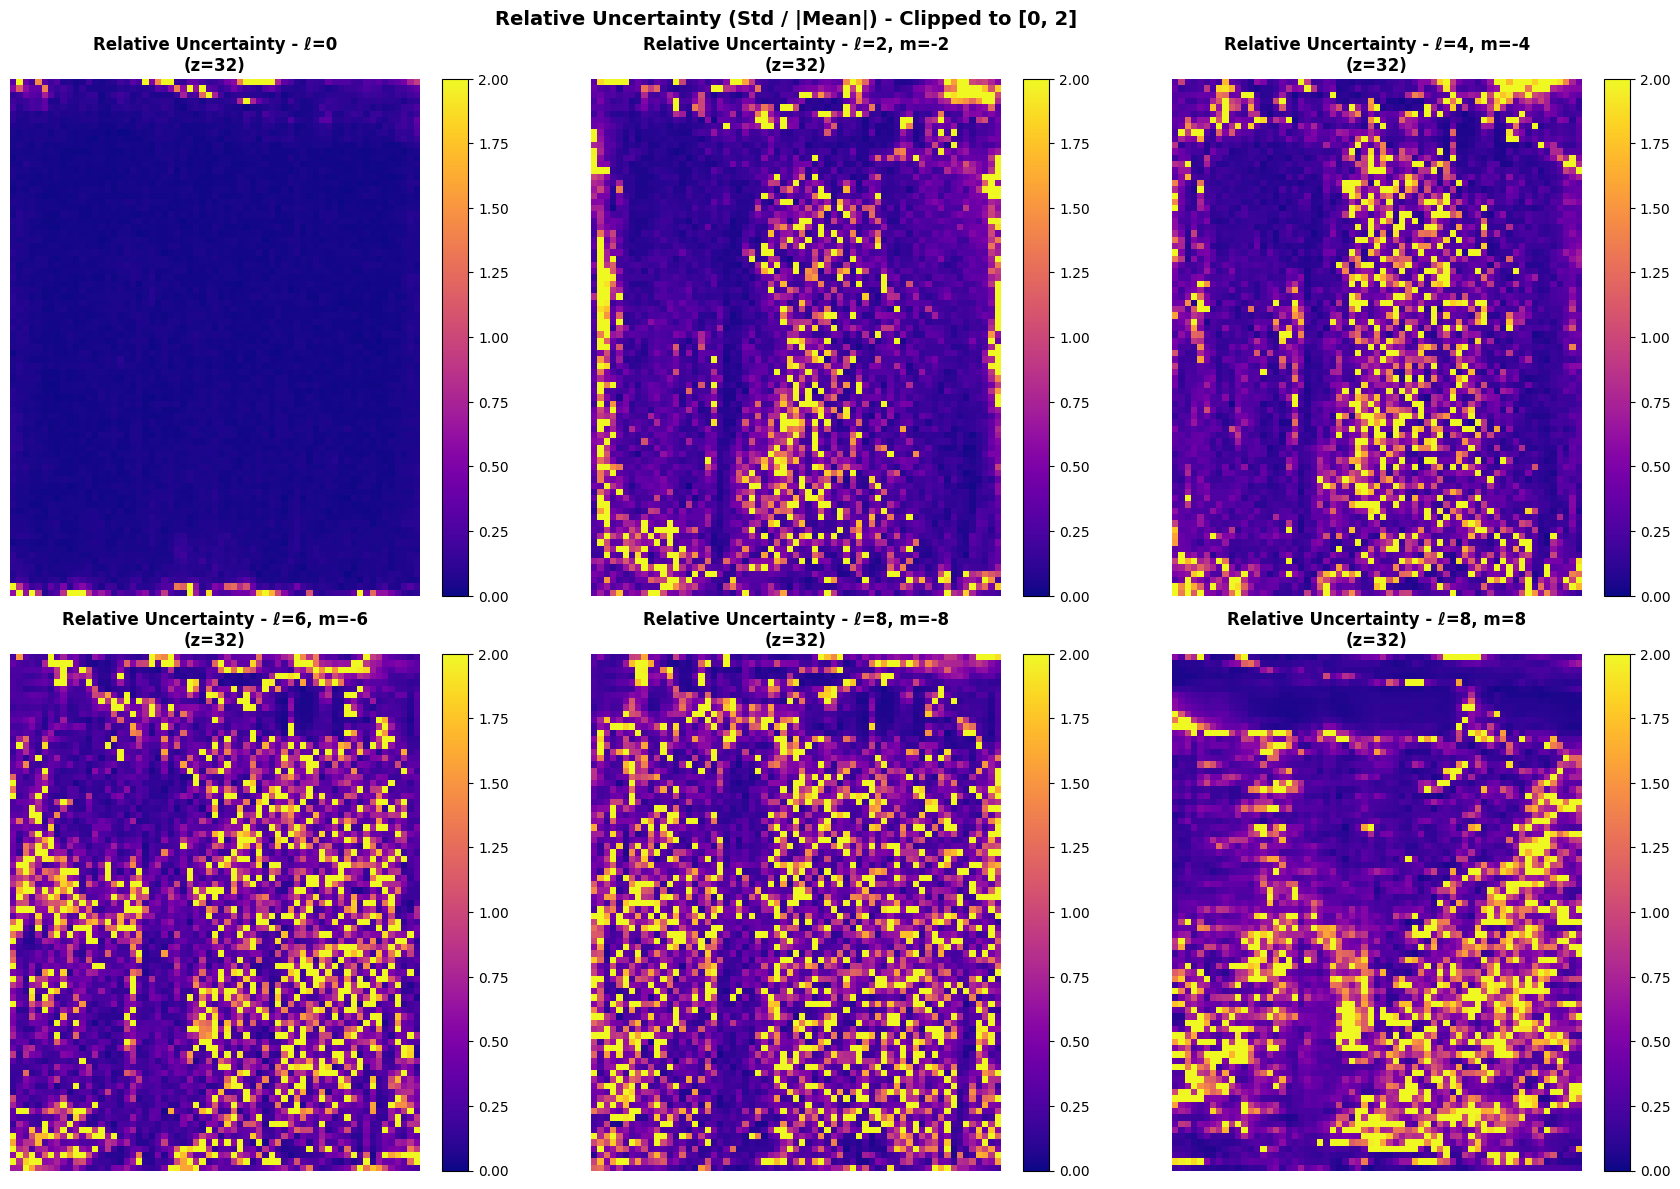

In [98]:
# Visualize relative uncertainty for selected coefficients
coeffs_to_plot = [0, 1, 6, 15, 28, 44]
coeff_labels = ['ℓ=0', 'ℓ=2, m=-2', 'ℓ=4, m=-4', 'ℓ=6, m=-6', 'ℓ=8, m=-8', 'ℓ=8, m=8']
mid_z = volume_shape[2] // 2

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (coeff_idx, label) in enumerate(zip(coeffs_to_plot, coeff_labels)):
    rel_unc_slice = relative_uncertainty_clipped[:, :, mid_z, coeff_idx]
    
    im = axes[idx].imshow(rel_unc_slice.T, cmap='plasma', origin='lower', vmin=0, vmax=2)
    axes[idx].set_title(f'Relative Uncertainty - {label}\n(z={mid_z})', fontsize=12, fontweight='bold')
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

fig.suptitle(f'Relative Uncertainty (Std / |Mean|) - Clipped to [0, 2]', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 12. Save Results (Optional)

In [99]:
# Optionally save results to HDF5
save_results = False  # Set to True to save
output_path = '/myhome/smartt/results/sparse_uncertainty_analysis.h5'

if save_results:
    print(f"Saving results to {output_path}...")
    
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    
    with h5py.File(output_path, 'w') as f:
        # Save reconstructions
        f.create_dataset('all_reconstructions', data=all_reconstructions, compression='gzip')
        f.create_dataset('mean_reconstruction', data=mean_reconstruction, compression='gzip')
        f.create_dataset('std_reconstruction', data=std_reconstruction, compression='gzip')
        f.create_dataset('ground_truth', data=ground_truth, compression='gzip')
        
        # Save indices
        f.create_dataset('fixed_sparse_indices', data=fixed_sparse_indices)
        for i, indices in enumerate(subsample_indices_list):
            f.create_dataset(f'subsample_indices_{i}', data=indices)
        
        # Save metadata
        f.attrs['ell_max'] = ell_max
        f.attrs['num_experiments'] = num_experiments
        f.attrs['num_projections_sparse'] = num_projections_sparse
        f.attrs['num_subsamples'] = num_subsamples
        f.attrs['total_projections'] = total_projections
        f.attrs['volume_shape'] = volume_shape
        f.attrs['num_coeffs'] = num_coeffs
        f.attrs['seed'] = seed
    
    print(f"Results saved successfully!")
else:
    print("Results not saved (set save_results=True to save)")

Results not saved (set save_results=True to save)


## Summary

This notebook demonstrates:
1. **Ground Truth**: Computed using all 240 available projections
2. **Fixed Sparse Subset**: 60 projections randomly selected and fixed
3. **Multiple Experiments**: 20 reconstructions, each using 48 randomly sampled projections from the fixed subset
4. **Uncertainty Quantification**: Standard deviation across experiments shows reconstruction uncertainty
5. **Coefficient Analysis**: Different spherical harmonic coefficients show varying levels of uncertainty
6. **Relative Uncertainty**: Normalized by signal strength to identify problematic regions

Key findings:
- Higher-order coefficients (larger ℓ values) typically show higher uncertainty
- Regions with low signal show higher relative uncertainty
- The standard deviation provides a measure of reconstruction stability given sparse sampling

## 13. Forward Project Reconstructions to Analyze Angular Variability

We'll project each reconstruction through all projection angles and analyze which angles show the highest variability across experiments.

In [100]:
# Create projector using the full geometry from dc_full
print("Creating projector with full geometry...")
projector_full = SAXSProjector(dc_full.geometry)

# Create basis set for forward projection
basis_set = SphericalHarmonics(ell_max=ell_max, probed_coordinates=dc_full.geometry.probed_coordinates)

print(f"Projector geometry:")
print(f"  Number of projections: {len(dc_full.geometry.inner_angles)}")
print(f"  Projection shape: {dc_full.geometry.projection_shape}")
print(f"  Detector angles: {dc_full.geometry.detector_angles.shape}")

num_angles = len(dc_full.geometry.inner_angles)
proj_shape = dc_full.geometry.projection_shape
num_detector_angles = len(dc_full.geometry.detector_angles)

print(f"\nExpected output shape per reconstruction: ({num_angles}, {proj_shape[0]}, {proj_shape[1]}, {num_detector_angles})")
print(f"Expected output shape for all reconstructions: ({num_experiments}, {num_angles}, {proj_shape[0]}, {proj_shape[1]}, {num_detector_angles})")

Creating projector with full geometry...


/opt/conda/lib/python3.10/site-packages/mumott/methods/basis_sets/spherical_harmonics.py:103: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  complex_factors = sph_harm(abs(self._emm_indices)[np.newaxis, np.newaxis, np.newaxis, ...],


Projector geometry:
  Number of projections: 240
  Projection shape: [ 73 100]
  Detector angles: (8,)

Expected output shape per reconstruction: (240, 73, 100, 8)
Expected output shape for all reconstructions: (5, 240, 73, 100, 8)


In [101]:
# Forward project all reconstructions
print(f"\nForward projecting {num_experiments} reconstructions through {num_angles} angles...")
print("This may take several minutes...\n")

# Pre-allocate array for all forward projections
all_forward_projections = np.zeros(
    (num_experiments, num_angles, proj_shape[0], proj_shape[1], num_detector_angles),
    dtype=np.float32
)

for exp_idx in tqdm(range(num_experiments), desc="Forward projecting"):
    reconstruction = all_reconstructions[exp_idx].astype(np.float64)
    
    # Forward project: projector.forward() then basis_set.forward()
    spatial_projection = projector_full.forward(reconstruction)
    forward_proj = basis_set.forward(spatial_projection)
    
    all_forward_projections[exp_idx] = forward_proj.astype(np.float32)
    
    # Clean up
    del reconstruction, spatial_projection, forward_proj

print(f"\nForward projections shape: {all_forward_projections.shape}")
print(f"Expected shape: ({num_experiments}, {num_angles}, {proj_shape[0]}, {proj_shape[1]}, {num_detector_angles})")


Forward projecting 5 reconstructions through 240 angles...
This may take several minutes...



Forward projecting: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


Forward projections shape: (5, 240, 73, 100, 8)
Expected shape: (5, 240, 73, 100, 8)


In [102]:
# Compute standard deviation across experiments for each angle
print("Computing variability across experiments for each projection angle...")

# Compute std across experiments (axis 0) for each angle
# Result shape: (num_angles, proj_shape[0], proj_shape[1], num_detector_angles)
std_per_angle = np.std(all_forward_projections, axis=0)

# Compute total variability per angle (sum of variance across all pixels and detector angles)
variability_per_angle = np.sum(std_per_angle**2, axis=(1, 2, 3))

print(f"\nStandard deviation per angle shape: {std_per_angle.shape}")
print(f"Variability per angle shape: {variability_per_angle.shape}")
print(f"\nVariability statistics:")
print(f"  Mean: {np.mean(variability_per_angle):.4f}")
print(f"  Median: {np.median(variability_per_angle):.4f}")
print(f"  Min: {np.min(variability_per_angle):.4f}")
print(f"  Max: {np.max(variability_per_angle):.4f}")

Computing variability across experiments for each projection angle...

Standard deviation per angle shape: (240, 73, 100, 8)
Variability per angle shape: (240,)

Variability statistics:
  Mean: 14587727872.0000
  Median: 8388352000.0000
  Min: 3002239232.0000
  Max: 88624136192.0000


In [103]:
# Find angles with highest and lowest variability
num_top_angles = 20

# Get indices sorted by variability
sorted_indices = np.argsort(variability_per_angle)[::-1]  # Descending order

# Top 20 most variable angles
top_variable_indices = sorted_indices[:num_top_angles]
top_variable_values = variability_per_angle[top_variable_indices]

# Bottom 20 least variable angles
least_variable_indices = sorted_indices[-num_top_angles:]
least_variable_values = variability_per_angle[least_variable_indices]

print(f"Top {num_top_angles} most variable angles:")
for i, (idx, val) in enumerate(zip(top_variable_indices, top_variable_values)):
    print(f"  {i+1}. Angle {idx}: variability = {val:.4f}")

print(f"\nTop {num_top_angles} least variable angles:")
for i, (idx, val) in enumerate(zip(least_variable_indices, least_variable_values)):
    print(f"  {i+1}. Angle {idx}: variability = {val:.4f}")

Top 20 most variable angles:
  1. Angle 47: variability = 88624136192.0000
  2. Angle 1: variability = 77520191488.0000
  3. Angle 49: variability = 65691394048.0000
  4. Angle 2: variability = 63913603072.0000
  5. Angle 48: variability = 53261086720.0000
  6. Angle 239: variability = 50428141568.0000
  7. Angle 202: variability = 50428141568.0000
  8. Angle 56: variability = 50428141568.0000
  9. Angle 86: variability = 50428141568.0000
  10. Angle 127: variability = 50428141568.0000
  11. Angle 161: variability = 50428141568.0000
  12. Angle 0: variability = 50428141568.0000
  13. Angle 55: variability = 45543231488.0000
  14. Angle 46: variability = 40615993344.0000
  15. Angle 3: variability = 37673512960.0000
  16. Angle 123: variability = 36704571392.0000
  17. Angle 57: variability = 35540668416.0000
  18. Angle 107: variability = 34886094848.0000
  19. Angle 85: variability = 31709448192.0000
  20. Angle 41: variability = 31049818112.0000

Top 20 least variable angles:
  1. An

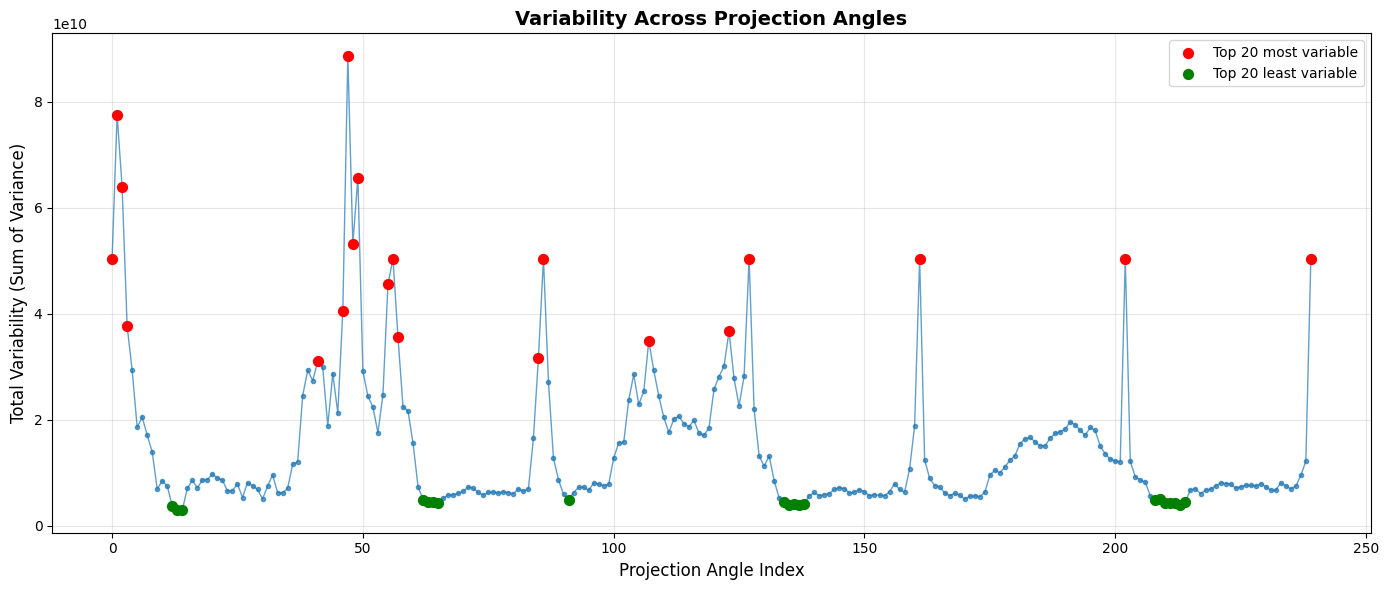

In [104]:
# Plot variability as a function of angle index
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(variability_per_angle, 'o-', linewidth=1, markersize=3, alpha=0.7)
ax.scatter(top_variable_indices, top_variable_values, color='red', s=50, 
           label=f'Top {num_top_angles} most variable', zorder=5)
ax.scatter(least_variable_indices, least_variable_values, color='green', s=50,
           label=f'Top {num_top_angles} least variable', zorder=5)

ax.set_xlabel('Projection Angle Index', fontsize=12)
ax.set_ylabel('Total Variability (Sum of Variance)', fontsize=12)
ax.set_title('Variability Across Projection Angles', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3D Visualization of High-Variability Angles

Visualize the projection angles with the highest variability on a 3D sphere.

In [105]:
# Extract rotation and tilt angles from geometry
rotation_angles_rad = dc_full.geometry.inner_angles[:]
tilt_angles_rad = list(np.pi/2 - np.array(dc_full.geometry.outer_angles))[:]

# Convert to Cartesian coordinates on unit sphere
r = 1
x_all = r * np.sin(tilt_angles_rad) * np.cos(rotation_angles_rad)
y_all = r * np.sin(tilt_angles_rad) * np.sin(rotation_angles_rad)
z_all = r * np.cos(tilt_angles_rad)

# Extract coordinates for high-variability angles
x_high_var = x_all[top_variable_indices]
y_high_var = y_all[top_variable_indices]
z_high_var = z_all[top_variable_indices]

print(f"Plotted {len(x_all)} total angles")
print(f"Highlighted {len(x_high_var)} high-variability angles in red")

Plotted 240 total angles
Highlighted 20 high-variability angles in red


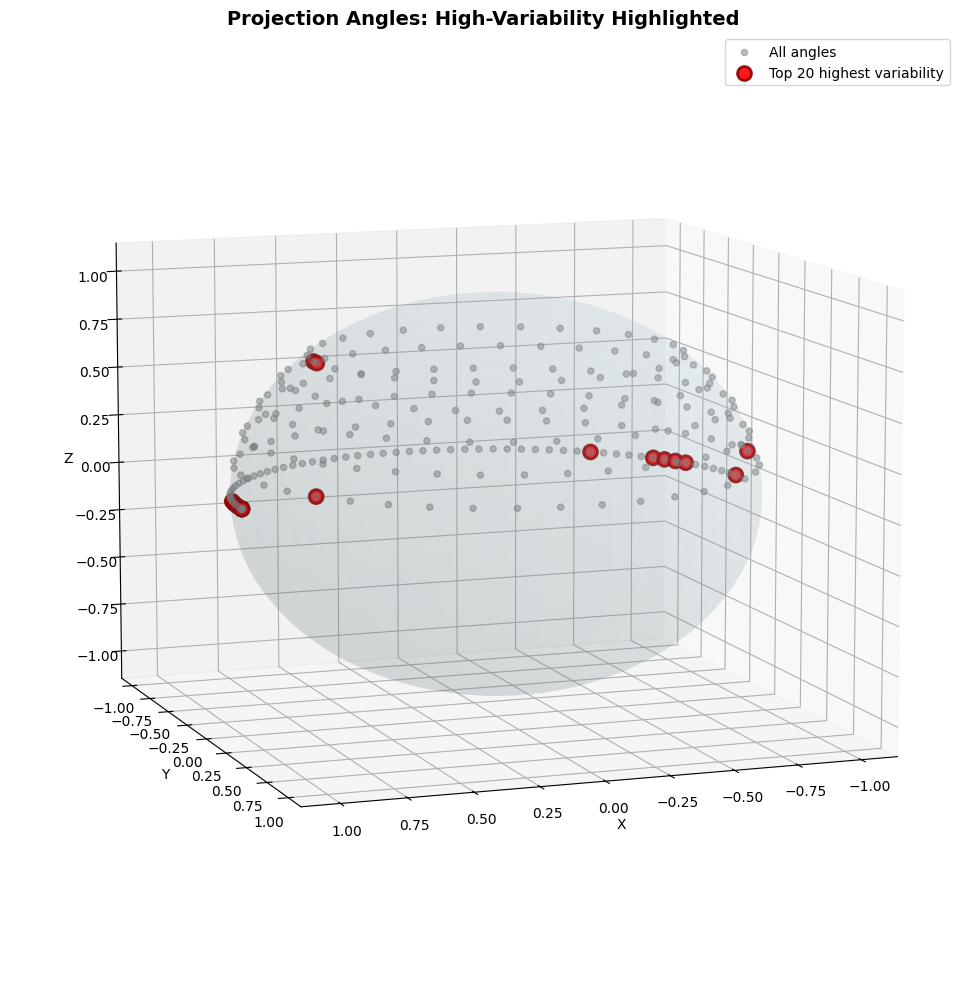

In [106]:
# Create 3D sphere plot showing all angles and highlighting high-variability ones
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create sphere surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
X = r * np.outer(np.cos(u), np.sin(v))
Y = r * np.outer(np.sin(u), np.sin(v))
Z = r * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot sphere (semi-transparent)
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.1)

# Plot all projection angles (gray)
ax.scatter(x_all, y_all, z_all, color='gray', s=20, alpha=0.5, label='All angles')

# Highlight high-variability angles (red)
ax.scatter(x_high_var, y_high_var, z_high_var, color='red', s=100, 
           alpha=0.9, edgecolors='darkred', linewidths=2,
           label=f'Top {num_top_angles} highest variability')

ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)
ax.set_title('Projection Angles: High-Variability Highlighted', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.view_init(elev=10, azim=70)

plt.tight_layout()
plt.show()

Fixed sparse subset: 60 angles
Top high-variability: 20 angles
Overlap between fixed sparse subset and top 20 high-variability: 12 angles
Overlap indices: [ 0  1  2  3 41 46 47 48 49 55 56 57]


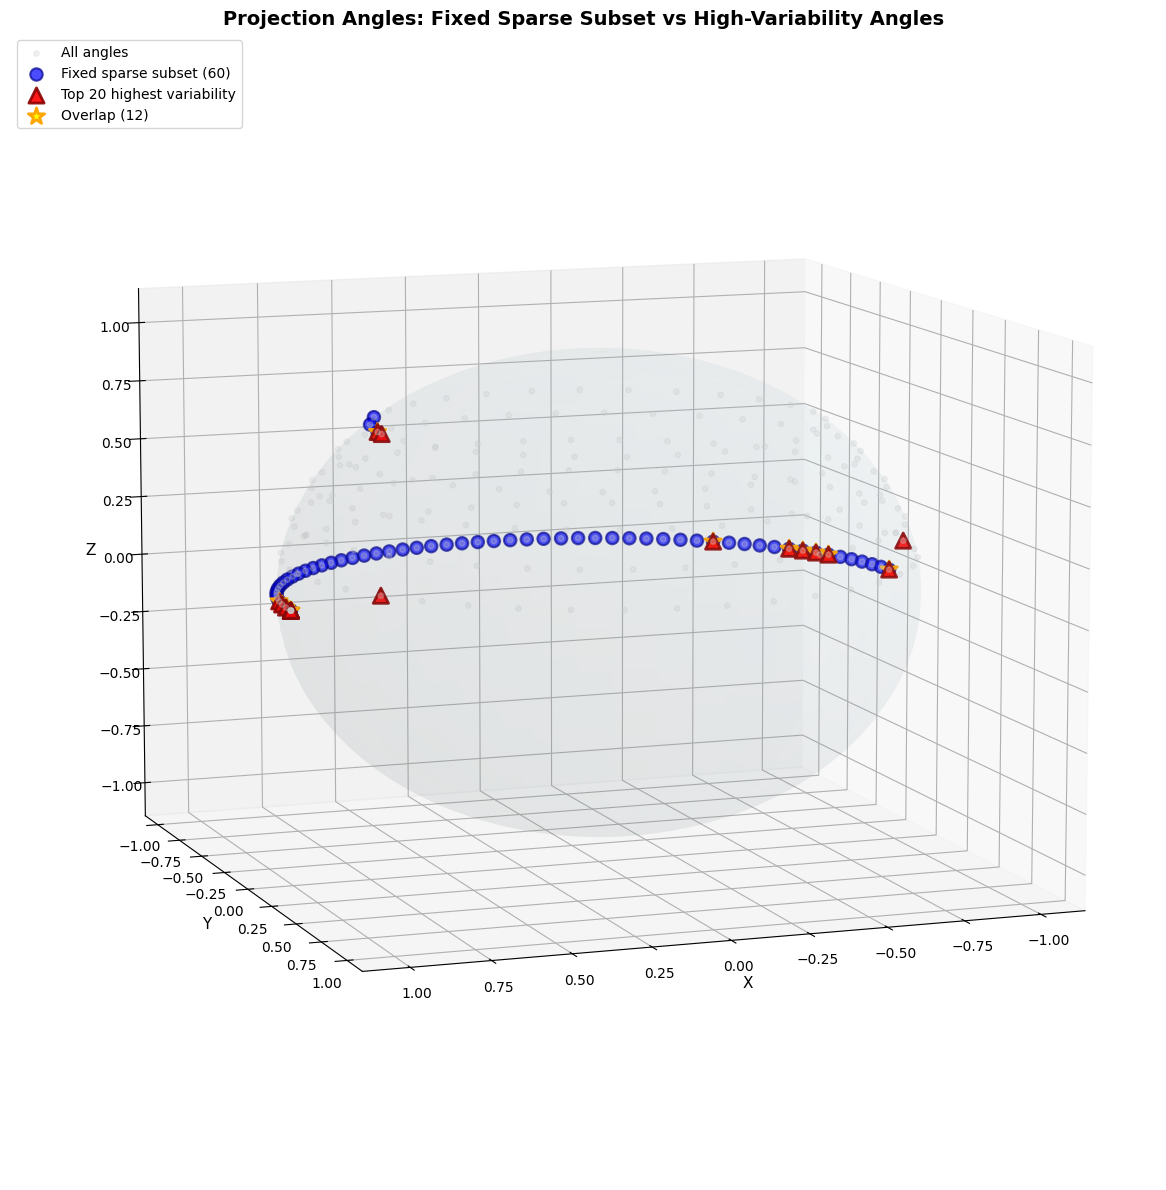

In [114]:
# Compare fixed sparse subset vs high-variability angles in 3D
# Extract coordinates for fixed sparse subset angles
x_sparse = x_all[fixed_sparse_indices]
y_sparse = y_all[fixed_sparse_indices]
z_sparse = z_all[fixed_sparse_indices]

print(f"Fixed sparse subset: {len(fixed_sparse_indices)} angles")
print(f"Top high-variability: {len(top_variable_indices)} angles")

# Check overlap between fixed sparse subset and high-variability angles
overlap = np.intersect1d(fixed_sparse_indices, top_variable_indices)
print(f"Overlap between fixed sparse subset and top {num_top_angles} high-variability: {len(overlap)} angles")
print(f"Overlap indices: {overlap}")

# Create 3D sphere plot
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot sphere surface (semi-transparent)
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.05)

# Plot all projection angles (light gray, small)
ax.scatter(x_all, y_all, z_all, color='lightgray', s=15, alpha=0.3, label='All angles')

# Plot fixed sparse subset (blue)
ax.scatter(x_sparse, y_sparse, z_sparse, color='blue', s=80, 
           alpha=0.7, edgecolors='darkblue', linewidths=1.5,
           label=f'Fixed sparse subset ({len(fixed_sparse_indices)})')

# Plot high-variability angles (red) - these will appear on top
ax.scatter(x_high_var, y_high_var, z_high_var, color='red', s=120, 
           alpha=0.9, edgecolors='darkred', linewidths=2,
           label=f'Top {num_top_angles} highest variability', marker='^')

# Highlight overlap if any (yellow stars)
if len(overlap) > 0:
    x_overlap = x_all[overlap]
    y_overlap = y_all[overlap]
    z_overlap = z_all[overlap]
    ax.scatter(x_overlap, y_overlap, z_overlap, color='yellow', s=150,
               alpha=1.0, edgecolors='orange', linewidths=2,
               label=f'Overlap ({len(overlap)})', marker='*', zorder=10)

ax.set_xlabel('X', fontsize=11)
ax.set_ylabel('Y', fontsize=11)
ax.set_zlabel('Z', fontsize=11)
ax.set_title(f'Projection Angles: Fixed Sparse Subset vs High-Variability Angles', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='upper left')
ax.view_init(elev=10, azim=70)

plt.tight_layout()
plt.show()

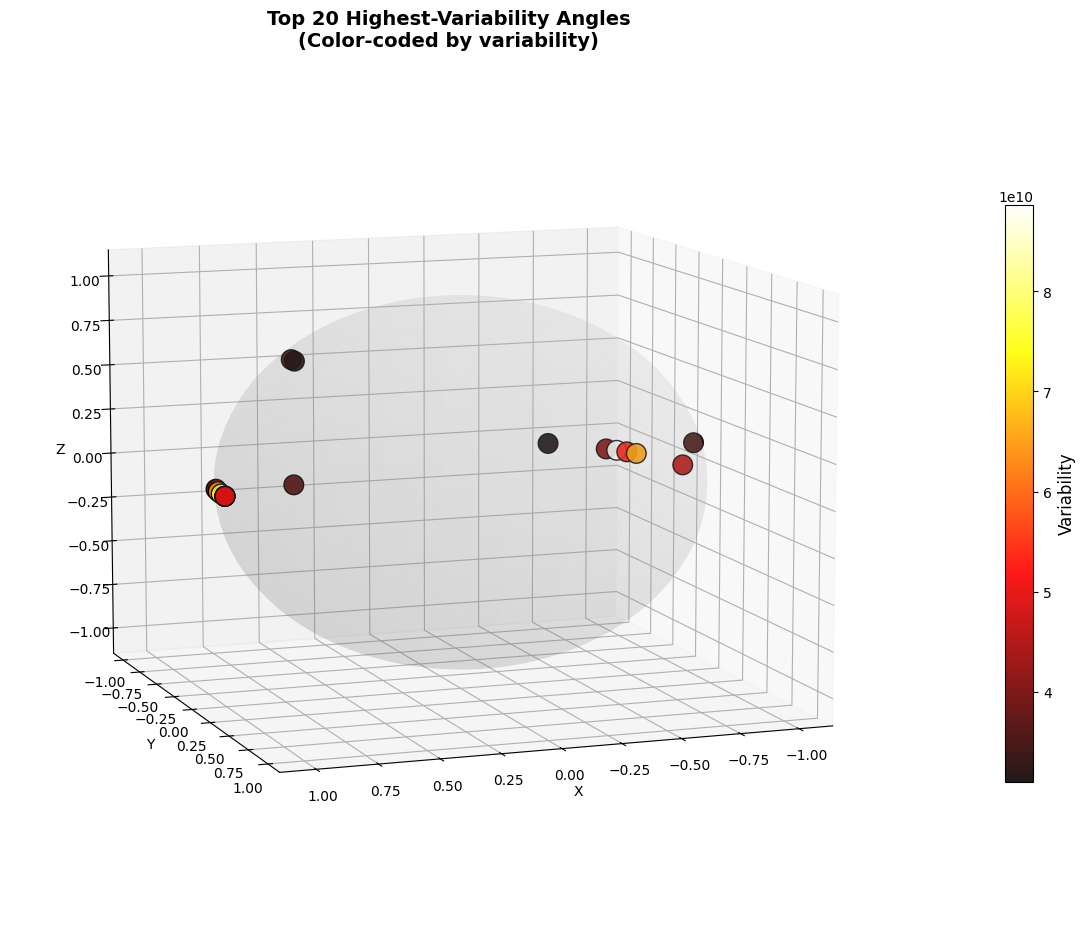

In [107]:
# Create another view focusing only on high-variability angles
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create sphere surface
ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1)

# Plot only high-variability angles with color scale based on variability
scatter = ax.scatter(x_high_var, y_high_var, z_high_var, 
                     c=top_variable_values, s=200, cmap='hot',
                     alpha=0.9, edgecolors='black', linewidths=1)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label('Variability', fontsize=12)

ax.set_xlabel('X', fontsize=10)
ax.set_ylabel('Y', fontsize=10)
ax.set_zlabel('Z', fontsize=10)
ax.set_title(f'Top {num_top_angles} Highest-Variability Angles\n(Color-coded by variability)', 
             fontsize=14, fontweight='bold')
ax.view_init(elev=10, azim=70)

plt.tight_layout()
plt.show()

### Compare Projections at Most and Least Variable Angles

Visualize the actual projection images at angles with highest and lowest variability.

In [108]:
# Select a few angles to visualize in detail
num_angles_to_show = 3
detector_angle_idx = 0  # Show one detector angle

# Most variable angles
high_var_angles = top_variable_indices[:num_angles_to_show]
high_var_labels = [f"Angle {idx}\nVar={variability_per_angle[idx]:.2f}" 
                   for idx in high_var_angles]

# Least variable angles  
low_var_angles = least_variable_indices[:num_angles_to_show]
low_var_labels = [f"Angle {idx}\nVar={variability_per_angle[idx]:.2f}" 
                  for idx in low_var_angles]

print(f"Visualizing detector angle index {detector_angle_idx}")
print(f"\nMost variable angles: {high_var_angles}")
print(f"Least variable angles: {low_var_angles}")

Visualizing detector angle index 0

Most variable angles: [47  1 49]
Least variable angles: [209  62  91]


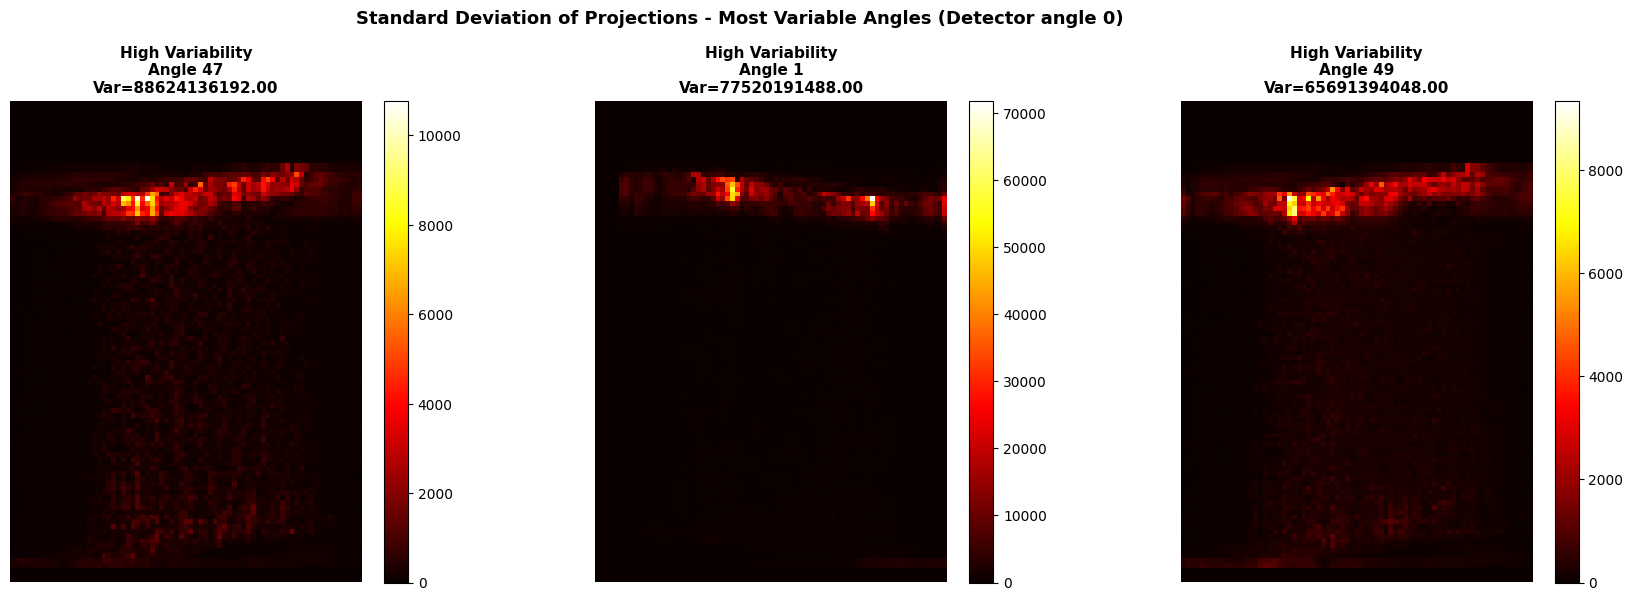

In [109]:
# Plot standard deviation projections for high-variability angles
fig, axes = plt.subplots(1, num_angles_to_show, figsize=(18, 6))

for i, (angle_idx, label) in enumerate(zip(high_var_angles, high_var_labels)):
    std_proj = std_per_angle[angle_idx, :, :, detector_angle_idx]
    
    im = axes[i].imshow(std_proj.T, cmap='hot', origin='lower')
    axes[i].set_title(f'High Variability\n{label}', fontsize=11, fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

fig.suptitle(f'Standard Deviation of Projections - Most Variable Angles (Detector angle {detector_angle_idx})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

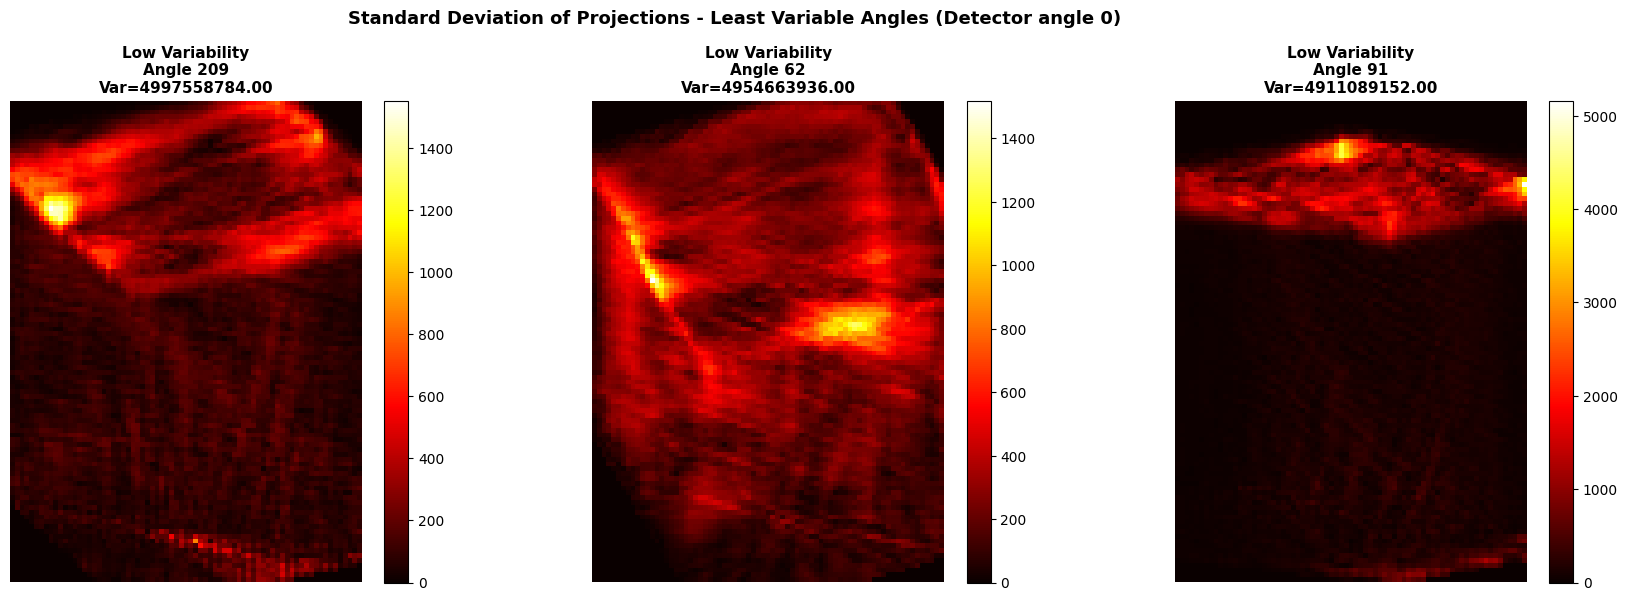

In [110]:
# Plot standard deviation projections for low-variability angles
fig, axes = plt.subplots(1, num_angles_to_show, figsize=(18, 6))

for i, (angle_idx, label) in enumerate(zip(low_var_angles, low_var_labels)):
    std_proj = std_per_angle[angle_idx, :, :, detector_angle_idx]
    
    im = axes[i].imshow(std_proj.T, cmap='hot', origin='lower')
    axes[i].set_title(f'Low Variability\n{label}', fontsize=11, fontweight='bold')
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

fig.suptitle(f'Standard Deviation of Projections - Least Variable Angles (Detector angle {detector_angle_idx})',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

Computing ground truth projection for angle 47...


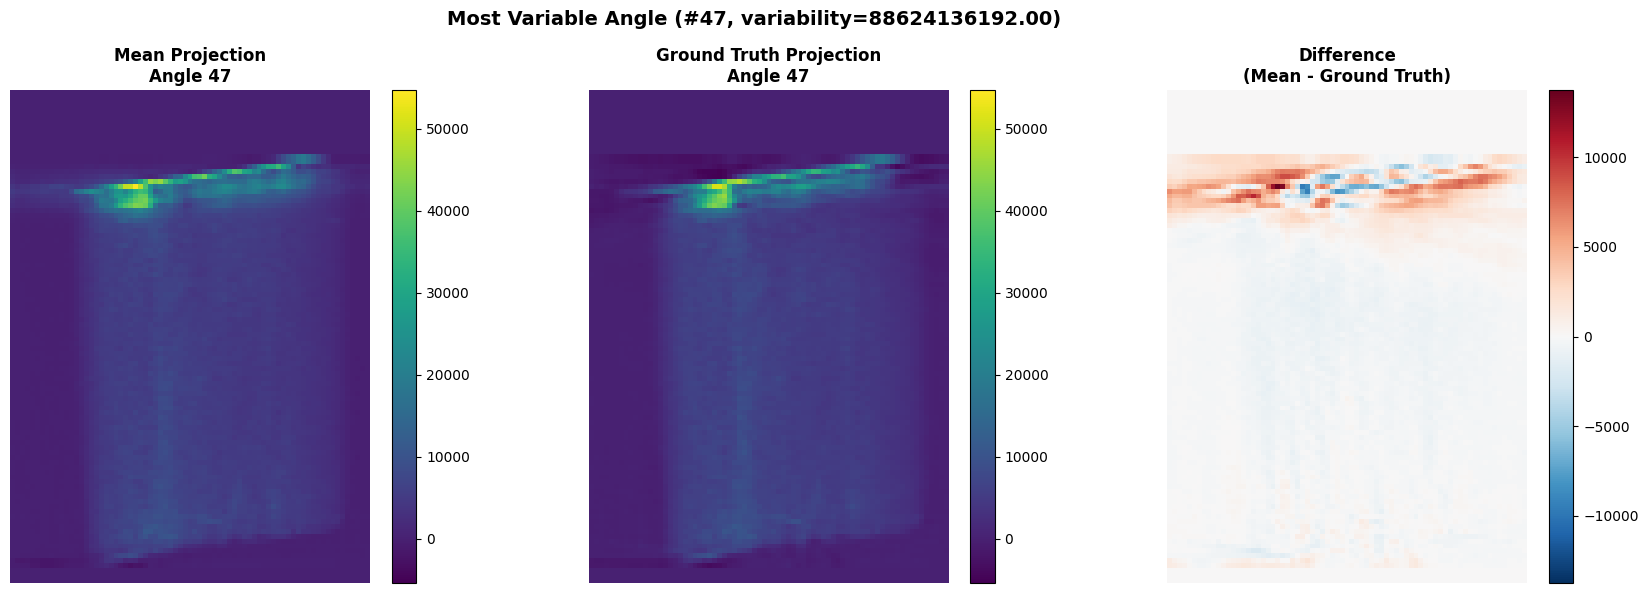


MSE between mean and ground truth projection: 1824447.508213


In [111]:
# Compare mean projections from experiments vs ground truth for highest variability angle
most_variable_angle = top_variable_indices[0]

# Compute mean projection across experiments
mean_projection = np.mean(all_forward_projections[:, most_variable_angle, :, :, detector_angle_idx], axis=0)

# Get ground truth projection (need to project ground truth)
print(f"Computing ground truth projection for angle {most_variable_angle}...")
gt_spatial_proj = projector_full.forward(ground_truth.astype(np.float64))
gt_forward_proj = basis_set.forward(gt_spatial_proj)
gt_projection = gt_forward_proj[most_variable_angle, :, :, detector_angle_idx]

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

vmin = min(mean_projection.min(), gt_projection.min())
vmax = max(mean_projection.max(), gt_projection.max())

# Mean projection
im0 = axes[0].imshow(mean_projection.T, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
axes[0].set_title(f'Mean Projection\nAngle {most_variable_angle}', fontsize=12, fontweight='bold')
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

# Ground truth projection
im1 = axes[1].imshow(gt_projection.T, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
axes[1].set_title(f'Ground Truth Projection\nAngle {most_variable_angle}', fontsize=12, fontweight='bold')
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# Difference
diff = mean_projection - gt_projection
im2 = axes[2].imshow(diff.T, cmap='RdBu_r', origin='lower',
                     vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
axes[2].set_title('Difference\n(Mean - Ground Truth)', fontsize=12, fontweight='bold')
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

fig.suptitle(f'Most Variable Angle (#{most_variable_angle}, variability={variability_per_angle[most_variable_angle]:.2f})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nMSE between mean and ground truth projection: {np.mean((mean_projection - gt_projection)**2):.6f}")